# Notebook for predicting Goldprice using LSTM
# 11.8.2023 

In [1]:
# importing the necessary packages:
from GoldFun import *   # for plotting and saving
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import tensorflow_probability as tfp
from matplotlib.pyplot import plot,figure,rc
from datetime import datetime, timedelta
import keras.backend as K
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import BatchNormalization,Dropout
import subprocess as sp
tmp = sp.call('cls',shell=True)
tfd = tfp.distributions

In [2]:
# load data from:
# https://www.kaggle.com/datasets/sid321axn/gold-price-prediction-dataset
fn2='FINAL_USO.csv'
df=pd.read_csv(fn2) 

## Feature selection

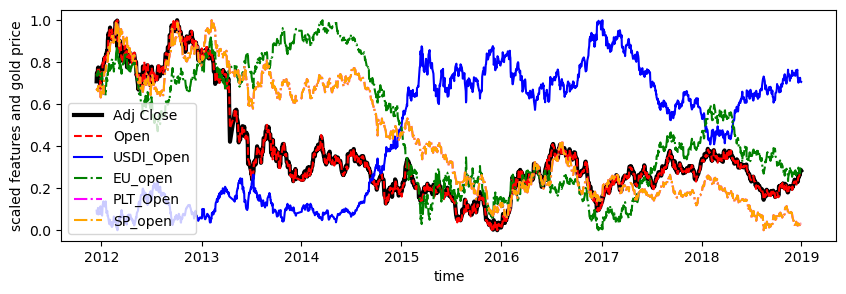

In [3]:
# features=['Adj Close','Open','GDX_Open','SF_Open','EG_open'] #correlation based
features=['Adj Close', 'Open','USDI_Open','EU_open', 'PLT_Open','SP_open'] # linear regression based
data0 = df.loc[:, features]
# In[7]:
scaler = MinMaxScaler()   # Data between 0 and 1
data1=data0.to_numpy()
data = scaler.fit_transform(data1)
#time plots:
date0=df['Date']
date = pd.to_datetime(df['Date'])
daten=date0.to_numpy()

fig1=figure(figsize=(10, 3), dpi=100)
plt.ylabel("scaled features and gold price")
plt.xlabel("time")

plt.plot(date, data[:, 0], label=features[0], color='black', linestyle='solid',linewidth=3)
plt.plot(date, data[:, 1], label=features[1], color='red', linestyle='dashed')
plt.plot(date, data[:, 2], label=features[2], color='blue', linestyle='solid')
plt.plot(date, data[:, 3], label=features[3], color='green', linestyle='dashdot')
plt.plot(date, data[:, 4], label=features[4], color='magenta', linestyle='dashdot')
plt.plot(date, data[:, 4], label=features[5], color='orange', linestyle='dashdot')

plt.legend()
plt.show()

# Defining sequence lengths and test-train split

In [5]:
sequence_length = 10  #  40 quartale
forecast_length = 30
# Wir erestellen eine Prognose für die nächsten forecast_length
# Das Fenster um eine Schrittweite von 1 verschieben
sequence_step = 1

ld0=len(data)
rt=0.8
ntr0=round(ld0*rt) # 1374
nts0=ld0-ntr0 # 376

x_ = []
y_ = []
date_=[]

#Reshaping to 3D Tensor happens here: 
#The loop starts from sequence_length, goes up to ld0 - forecast_length,and increments by sequence_step

lf=len(features)
for i in range(sequence_length, ld0-forecast_length, sequence_step):
    x_.append(data[i-sequence_length:i, 0:1])  # : für alle Merkmale x
    y_.append(data[i:i+forecast_length, 0])  # 0 nur für y
    
x = np.array(x_) # past of gold price
y = np.array(y_)  # future of price

weight = np.ones(len(x))
weight[-forecast_length:] = np.arange(forecast_length)+1
# "Random" Test-Train Split
# The splitting according to time swquence doese not improve the results
x_train, x_test, y_train, y_test, weight_train, weight_test = train_test_split(
    x, y, weight, test_size=0.2, random_state=0)

# Definig the model 

In [7]:
epochs=2000 #++++++++
tf.random.set_seed(158)  # extra code – ensures reproducibility
#ensures that the random numbers generated by TensorFlow will be 
#the same across different runs, making your results reproducible
#%%
model = keras.models.Sequential()
model.add(keras.layers.LSTM(20, return_sequences=True,
                            #kernel_initializer='glorot_uniform',
                            #activation='tanh',
                            input_shape=[sequence_length,1], # 40,1 
                            ))
model.add(keras.layers.LSTM(100, return_sequences=True,
                            ))
model.add(keras.layers.LSTM(200, return_sequences=True,
                            ))
model.add(keras.layers.LSTM(100, return_sequences=False,
                            ))
model.add(keras.layers.Dense(100, activation='elu'))
model.add(keras.layers.Dense(20, activation='elu'))

#help stabilize training and accelerate convergence.
model.add(BatchNormalization())#######
#dropout_rate = 0.2
#model.add(Dropout(dropout_rate))#####
model.add(keras.layers.Dense(20, activation='elu'))
# Wir wollen die nächsten forecast_length vorhersagen, daher forecast_length Neuronen
model.add(keras.layers.Dense(forecast_length*2))

model.add(tfp.layers.DistributionLambda(
    lambda t: tfd.Normal(loc=tf.nn.sigmoid(
        t[:, 0:forecast_length]), 
        scale=1e-3 + tf.nn.softplus(t[:, forecast_length:]))))

optimizer = keras.optimizers.Adam(learning_rate=0.0002, epsilon=1e-07)
#optimizer = keras.optimizers.SGD(learning_rate=0.0002)
### Adam Optimizer predicts better than the SGD ###
model.compile(optimizer=optimizer,
              loss=negloglik, #
              #loss=tf.keras.losses.Huber(delta=1.0), #combination of MSE and MAE less sensitive to outliers.
#Smoothly transitions from MSE near the origin to MAE away from the origin.
               #='mean_squared_error',
              #loss=['mean_squared_error',negloglik],
              metrics=['mse','mae', r_squared,'accuracy'])
model.summary()

''' the overall loss as a combination of these individual losses,
 based on the weights you assign to each loss function.
 Keras optimize model's parameters to minimize both loss functions simultaneously'''
#*++++++++++++++++++Notes+++++++++++++++++++++++++++++++++++
#Larger epoche does not help, but smaller learning rate does....
#learning_rate=0.001 is the best

# Set up Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=150,
                               restore_best_weights=True)
def step_decay(epoch):
    initial_lr = 0.001
    drop_factor = 0.5  # 0.5
    epochs_drop = epochs/5  # 400e
    new_lr = initial_lr * (drop_factor ** (epoch // epochs_drop))
    return new_lr

lr_scheduler = LearningRateScheduler(step_decay)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 20)            1760      
                                                                 
 lstm_1 (LSTM)               (None, 10, 100)           48400     
                                                                 
 lstm_2 (LSTM)               (None, 10, 200)           240800    
                                                                 
 lstm_3 (LSTM)               (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 20)                2020      
                                                                 
 batch_normalization (Batch  (None, 20)                8

# Train the model and collect history

In [9]:
model.fit(x_train, y_train, epochs=epochs, batch_size=10,
                    validation_data=(x_test, y_test), callbacks=[early_stopping, lr_scheduler])

# model.fit(x_train, y_train, epochs=epochs, batch_size=10,
#                     validation_data=(x_test, y_test))

Epoch 1/2000
135/135 [==============================] - 10s 26ms/step - loss: 0.1019 - mse: 0.3576 - mae: 0.4086 - r_squared: -11.6608 - accuracy: 0.0313 - val_loss: -0.2345 - val_mse: 0.2356 - val_mae: 0.2966 - val_r_squared: -3.4801 - val_accuracy: 0.0268 - lr: 0.0010
Epoch 2/2000
135/135 [==============================] - 2s 16ms/step - loss: -0.5673 - mse: 0.0883 - mae: 0.1919 - r_squared: -4.0076 - accuracy: 0.0261 - val_loss: 0.6640 - val_mse: 0.0566 - val_mae: 0.1746 - val_r_squared: -0.3287 - val_accuracy: 0.0446 - lr: 0.0010
Epoch 3/2000
135/135 [==============================] - 2s 16ms/step - loss: -0.7276 - mse: 0.0424 - mae: 0.1476 - r_squared: -1.8934 - accuracy: 0.0402 - val_loss: -0.2918 - val_mse: 0.0293 - val_mae: 0.1392 - val_r_squared: 0.1811 - val_accuracy: 0.0179 - lr: 0.0010
Epoch 4/2000
135/135 [==============================] - 2s 16ms/step - loss: -0.8085 - mse: 0.0282 - mae: 0.1262 - r_squared: -0.4224 - accuracy: 0.0380 - val_loss: -0.7848 - val_mse: 0.0214 

135/135 [==============================] - 2s 16ms/step - loss: -1.1104 - mse: 0.0147 - mae: 0.0921 - r_squared: 0.2167 - accuracy: 0.0283 - val_loss: 0.2683 - val_mse: 0.0366 - val_mae: 0.1615 - val_r_squared: -0.1248 - val_accuracy: 0.0208 - lr: 0.0010
Epoch 32/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.2023 - mse: 0.0126 - mae: 0.0844 - r_squared: 0.5776 - accuracy: 0.0395 - val_loss: -0.5353 - val_mse: 0.0552 - val_mae: 0.1844 - val_r_squared: -0.5957 - val_accuracy: 0.0298 - lr: 0.0010
Epoch 33/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.1534 - mse: 0.0140 - mae: 0.0883 - r_squared: -0.1426 - accuracy: 0.0365 - val_loss: -0.4914 - val_mse: 0.0298 - val_mae: 0.1398 - val_r_squared: 0.1389 - val_accuracy: 0.0327 - lr: 0.0010
Epoch 34/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.0249 - mse: 0.0207 - mae: 0.1107 - r_squared: 0.0973 - accuracy: 0.0261 - val_loss: -0.1488 - val_mse: 0.0894 - val_mae: 0.2

135/135 [==============================] - 2s 16ms/step - loss: -1.3211 - mse: 0.0100 - mae: 0.0758 - r_squared: 0.5909 - accuracy: 0.0320 - val_loss: -0.5020 - val_mse: 0.0240 - val_mae: 0.1254 - val_r_squared: 0.3778 - val_accuracy: 0.0238 - lr: 0.0010
Epoch 62/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.2851 - mse: 0.0105 - mae: 0.0775 - r_squared: 0.6037 - accuracy: 0.0343 - val_loss: -1.0436 - val_mse: 0.0151 - val_mae: 0.0948 - val_r_squared: 0.5908 - val_accuracy: 0.0327 - lr: 0.0010
Epoch 63/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.3398 - mse: 0.0100 - mae: 0.0760 - r_squared: 0.6486 - accuracy: 0.0343 - val_loss: 0.6585 - val_mse: 0.0222 - val_mae: 0.1253 - val_r_squared: 0.3248 - val_accuracy: 0.0327 - lr: 0.0010
Epoch 64/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.3763 - mse: 0.0091 - mae: 0.0719 - r_squared: 0.6795 - accuracy: 0.0335 - val_loss: -0.6284 - val_mse: 0.0189 - val_mae: 0.1097

135/135 [==============================] - 2s 16ms/step - loss: -1.3792 - mse: 0.0089 - mae: 0.0716 - r_squared: 0.6802 - accuracy: 0.0402 - val_loss: 1.2863 - val_mse: 0.0103 - val_mae: 0.0756 - val_r_squared: 0.7520 - val_accuracy: 0.0298 - lr: 0.0010
Epoch 92/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.3515 - mse: 0.0100 - mae: 0.0749 - r_squared: 0.6539 - accuracy: 0.0335 - val_loss: -1.1354 - val_mse: 0.0107 - val_mae: 0.0785 - val_r_squared: 0.7016 - val_accuracy: 0.0417 - lr: 0.0010
Epoch 93/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.3652 - mse: 0.0093 - mae: 0.0727 - r_squared: 0.5941 - accuracy: 0.0417 - val_loss: -1.2137 - val_mse: 0.0139 - val_mae: 0.0916 - val_r_squared: 0.5978 - val_accuracy: 0.0119 - lr: 0.0010
Epoch 94/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.3554 - mse: 0.0097 - mae: 0.0735 - r_squared: 0.6672 - accuracy: 0.0395 - val_loss: -1.0604 - val_mse: 0.0105 - val_mae: 0.0777

135/135 [==============================] - 2s 16ms/step - loss: -1.3580 - mse: 0.0091 - mae: 0.0707 - r_squared: -0.0764 - accuracy: 0.0335 - val_loss: -0.5356 - val_mse: 0.0195 - val_mae: 0.1129 - val_r_squared: 0.4236 - val_accuracy: 0.0208 - lr: 0.0010
Epoch 122/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.1659 - mse: 0.0163 - mae: 0.0969 - r_squared: 0.3450 - accuracy: 0.0298 - val_loss: -0.6251 - val_mse: 0.0299 - val_mae: 0.1363 - val_r_squared: 0.1259 - val_accuracy: 0.0238 - lr: 0.0010
Epoch 123/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.3821 - mse: 0.0094 - mae: 0.0731 - r_squared: 0.5803 - accuracy: 0.0469 - val_loss: -1.2659 - val_mse: 0.0122 - val_mae: 0.0854 - val_r_squared: 0.6653 - val_accuracy: 0.0446 - lr: 0.0010
Epoch 124/2000
135/135 [==============================] - 2s 17ms/step - loss: -1.3884 - mse: 0.0093 - mae: 0.0721 - r_squared: 0.5916 - accuracy: 0.0373 - val_loss: -1.0823 - val_mse: 0.0121 - val_mae: 0

135/135 [==============================] - 2s 16ms/step - loss: -1.4404 - mse: 0.0081 - mae: 0.0681 - r_squared: 0.7036 - accuracy: 0.0261 - val_loss: -1.4066 - val_mse: 0.0093 - val_mae: 0.0734 - val_r_squared: 0.7514 - val_accuracy: 0.0327 - lr: 0.0010
Epoch 152/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4358 - mse: 0.0080 - mae: 0.0677 - r_squared: 0.7673 - accuracy: 0.0410 - val_loss: -1.3378 - val_mse: 0.0073 - val_mae: 0.0639 - val_r_squared: 0.8120 - val_accuracy: 0.0327 - lr: 0.0010
Epoch 153/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4296 - mse: 0.0082 - mae: 0.0675 - r_squared: 0.5677 - accuracy: 0.0268 - val_loss: -1.1936 - val_mse: 0.0105 - val_mae: 0.0789 - val_r_squared: 0.7192 - val_accuracy: 0.0506 - lr: 0.0010
Epoch 154/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.3737 - mse: 0.0105 - mae: 0.0759 - r_squared: 0.6264 - accuracy: 0.0268 - val_loss: -0.6789 - val_mse: 0.0159 - val_mae: 0.

135/135 [==============================] - 2s 16ms/step - loss: -1.4252 - mse: 0.0084 - mae: 0.0681 - r_squared: -0.0824 - accuracy: 0.0335 - val_loss: -1.1440 - val_mse: 0.0121 - val_mae: 0.0860 - val_r_squared: 0.6658 - val_accuracy: 0.0238 - lr: 0.0010
Epoch 182/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.3416 - mse: 0.0105 - mae: 0.0770 - r_squared: 0.5352 - accuracy: 0.0328 - val_loss: -1.0313 - val_mse: 0.0152 - val_mae: 0.0952 - val_r_squared: 0.5726 - val_accuracy: 0.0357 - lr: 0.0010
Epoch 183/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4057 - mse: 0.0092 - mae: 0.0715 - r_squared: 0.5738 - accuracy: 0.0291 - val_loss: -1.2909 - val_mse: 0.0098 - val_mae: 0.0761 - val_r_squared: 0.7325 - val_accuracy: 0.0208 - lr: 0.0010
Epoch 184/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4567 - mse: 0.0086 - mae: 0.0689 - r_squared: 0.6453 - accuracy: 0.0373 - val_loss: -0.2650 - val_mse: 0.0144 - val_mae: 0

135/135 [==============================] - 2s 16ms/step - loss: -1.4274 - mse: 0.0088 - mae: 0.0694 - r_squared: 0.7264 - accuracy: 0.0380 - val_loss: -0.4845 - val_mse: 0.0115 - val_mae: 0.0857 - val_r_squared: 0.6519 - val_accuracy: 0.0208 - lr: 0.0010
Epoch 212/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4521 - mse: 0.0078 - mae: 0.0665 - r_squared: 0.7483 - accuracy: 0.0343 - val_loss: -1.3131 - val_mse: 0.0087 - val_mae: 0.0713 - val_r_squared: 0.7590 - val_accuracy: 0.0298 - lr: 0.0010
Epoch 213/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4636 - mse: 0.0081 - mae: 0.0669 - r_squared: 0.7298 - accuracy: 0.0298 - val_loss: -0.8794 - val_mse: 0.0074 - val_mae: 0.0666 - val_r_squared: 0.7951 - val_accuracy: 0.0387 - lr: 0.0010
Epoch 214/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4157 - mse: 0.0088 - mae: 0.0694 - r_squared: 0.6877 - accuracy: 0.0402 - val_loss: -1.0567 - val_mse: 0.0080 - val_mae: 0.

135/135 [==============================] - 2s 16ms/step - loss: -1.4729 - mse: 0.0079 - mae: 0.0663 - r_squared: 0.6790 - accuracy: 0.0335 - val_loss: -1.3354 - val_mse: 0.0104 - val_mae: 0.0773 - val_r_squared: 0.7039 - val_accuracy: 0.0268 - lr: 0.0010
Epoch 242/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4453 - mse: 0.0085 - mae: 0.0681 - r_squared: 0.7418 - accuracy: 0.0402 - val_loss: -1.1389 - val_mse: 0.0170 - val_mae: 0.0977 - val_r_squared: 0.5744 - val_accuracy: 0.0476 - lr: 0.0010
Epoch 243/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4471 - mse: 0.0087 - mae: 0.0691 - r_squared: 0.6910 - accuracy: 0.0335 - val_loss: -0.2359 - val_mse: 0.0150 - val_mae: 0.0995 - val_r_squared: 0.5538 - val_accuracy: 0.0446 - lr: 0.0010
Epoch 244/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4693 - mse: 0.0079 - mae: 0.0666 - r_squared: 0.6874 - accuracy: 0.0395 - val_loss: -0.5772 - val_mse: 0.0079 - val_mae: 0.

135/135 [==============================] - 2s 16ms/step - loss: -1.5030 - mse: 0.0074 - mae: 0.0645 - r_squared: 0.7030 - accuracy: 0.0395 - val_loss: -1.0817 - val_mse: 0.0090 - val_mae: 0.0728 - val_r_squared: 0.7514 - val_accuracy: 0.0179 - lr: 0.0010
Epoch 272/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4608 - mse: 0.0078 - mae: 0.0662 - r_squared: 0.6848 - accuracy: 0.0447 - val_loss: -1.0702 - val_mse: 0.0134 - val_mae: 0.0898 - val_r_squared: 0.6538 - val_accuracy: 0.0298 - lr: 0.0010
Epoch 273/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4765 - mse: 0.0078 - mae: 0.0661 - r_squared: 0.7512 - accuracy: 0.0358 - val_loss: -0.7971 - val_mse: 0.0152 - val_mae: 0.0949 - val_r_squared: 0.6312 - val_accuracy: 0.0417 - lr: 0.0010
Epoch 274/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4692 - mse: 0.0080 - mae: 0.0668 - r_squared: 0.6642 - accuracy: 0.0410 - val_loss: -0.3281 - val_mse: 0.0142 - val_mae: 0.

135/135 [==============================] - 2s 16ms/step - loss: -1.4422 - mse: 0.0084 - mae: 0.0675 - r_squared: 0.5913 - accuracy: 0.0253 - val_loss: -1.3130 - val_mse: 0.0087 - val_mae: 0.0702 - val_r_squared: 0.7644 - val_accuracy: 0.0417 - lr: 0.0010
Epoch 302/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4804 - mse: 0.0081 - mae: 0.0666 - r_squared: 0.7153 - accuracy: 0.0380 - val_loss: -1.3547 - val_mse: 0.0080 - val_mae: 0.0668 - val_r_squared: 0.7754 - val_accuracy: 0.0476 - lr: 0.0010
Epoch 303/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4660 - mse: 0.0080 - mae: 0.0669 - r_squared: 0.6563 - accuracy: 0.0425 - val_loss: -1.3364 - val_mse: 0.0111 - val_mae: 0.0791 - val_r_squared: 0.7017 - val_accuracy: 0.0238 - lr: 0.0010
Epoch 304/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4738 - mse: 0.0077 - mae: 0.0657 - r_squared: 0.7095 - accuracy: 0.0469 - val_loss: -0.9677 - val_mse: 0.0175 - val_mae: 0.

135/135 [==============================] - 2s 16ms/step - loss: -1.4765 - mse: 0.0081 - mae: 0.0664 - r_squared: 0.7156 - accuracy: 0.0373 - val_loss: 0.0767 - val_mse: 0.0136 - val_mae: 0.0938 - val_r_squared: 0.6349 - val_accuracy: 0.0238 - lr: 0.0010
Epoch 332/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4957 - mse: 0.0075 - mae: 0.0647 - r_squared: 0.6907 - accuracy: 0.0328 - val_loss: -1.0733 - val_mse: 0.0068 - val_mae: 0.0620 - val_r_squared: 0.8175 - val_accuracy: 0.0417 - lr: 0.0010
Epoch 333/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4917 - mse: 0.0078 - mae: 0.0658 - r_squared: 0.6785 - accuracy: 0.0328 - val_loss: -1.2394 - val_mse: 0.0077 - val_mae: 0.0669 - val_r_squared: 0.7954 - val_accuracy: 0.0476 - lr: 0.0010
Epoch 334/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4939 - mse: 0.0075 - mae: 0.0646 - r_squared: 0.7475 - accuracy: 0.0373 - val_loss: -1.1060 - val_mse: 0.0144 - val_mae: 0.0

135/135 [==============================] - 2s 16ms/step - loss: -1.4929 - mse: 0.0077 - mae: 0.0656 - r_squared: 0.6889 - accuracy: 0.0328 - val_loss: -1.2869 - val_mse: 0.0088 - val_mae: 0.0717 - val_r_squared: 0.7399 - val_accuracy: 0.0327 - lr: 0.0010
Epoch 362/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.4864 - mse: 0.0079 - mae: 0.0656 - r_squared: 0.6736 - accuracy: 0.0402 - val_loss: -0.7068 - val_mse: 0.0134 - val_mae: 0.0896 - val_r_squared: 0.6398 - val_accuracy: 0.0387 - lr: 0.0010
Epoch 363/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.5054 - mse: 0.0076 - mae: 0.0645 - r_squared: 0.3294 - accuracy: 0.0365 - val_loss: -1.2381 - val_mse: 0.0079 - val_mae: 0.0675 - val_r_squared: 0.7884 - val_accuracy: 0.0327 - lr: 0.0010
Epoch 364/2000
135/135 [==============================] - 2s 16ms/step - loss: -1.5005 - mse: 0.0080 - mae: 0.0664 - r_squared: 0.7477 - accuracy: 0.0447 - val_loss: -1.3505 - val_mse: 0.0068 - val_mae: 0.

# Result:
Epoch 371/2000
135/135 [==============================] - 2s 16ms/step -
loss: -1.5142 - mse: 0.0075 - mae: 0.0640 - r_squared: 0.6852 
                - accuracy: 0.0410 - val_loss: -1.3156 - val_mse: 0.0082 - val_mae: 0.0685 - val_r_squared: 0.7711
                                    - val_accuracy: 0.0238 - lr: 0.0010

# plot loss and errors 

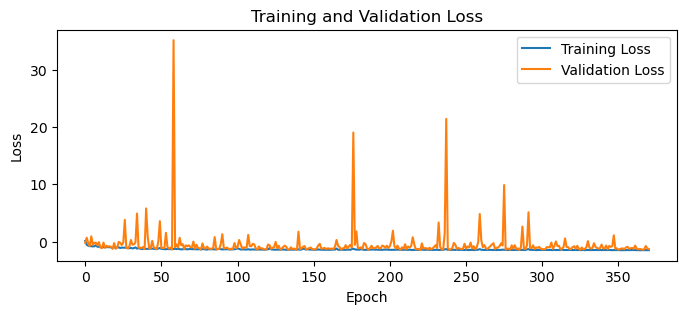

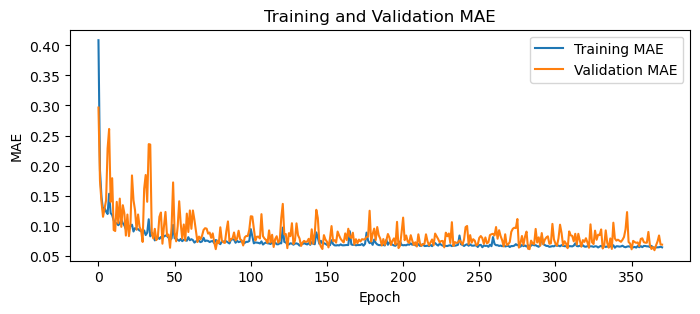

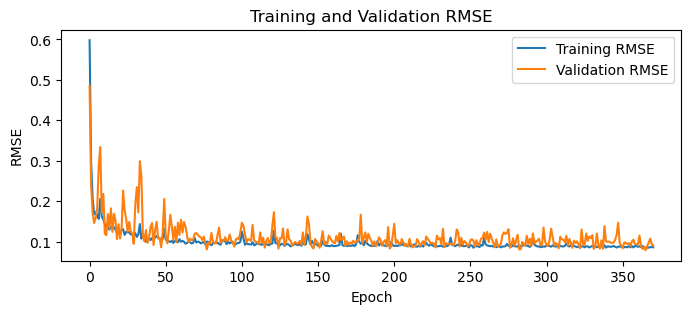

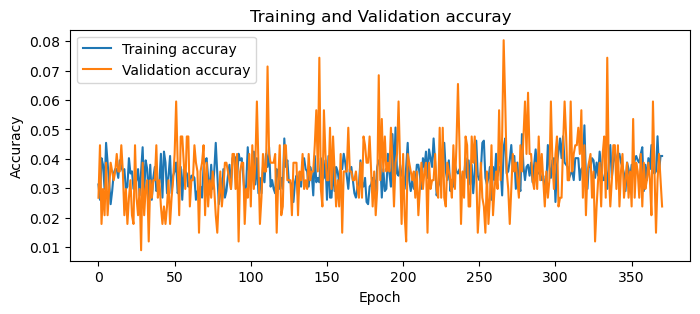

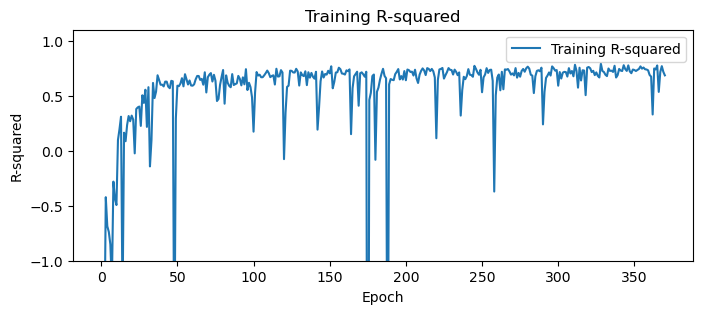

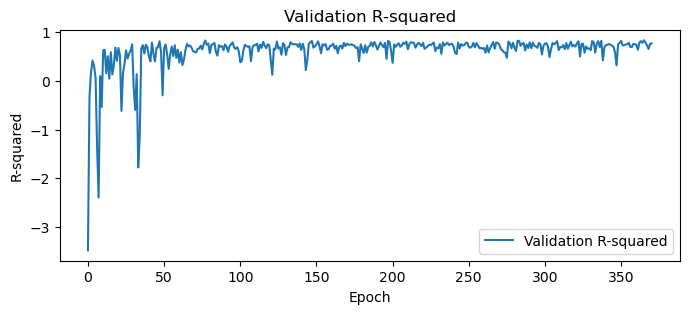

In [10]:
history = model.history.history
# Plot training metrics
plot_training_metrics(history)

In [11]:
daten1=daten.reshape(-1,1)
daten2 = np.vectorize(lambda date_str: datetime.strptime(date_str, '%Y-%m-%d'))(daten1)

zero_date=date0[ntr0]    # =  '2017-08-11'  + 10 days after this

start_date="2017-09-12 00:00:00"
# Convert the start_date string to a datetime object
target_date = pd.to_datetime(start_date)
# Find the indices where the condition is met
index= np.where(daten2 == target_date)[0]
print(index)
#index_in_data=index
#corresponding_index_in_x_test
index2 = (index - ntr0) * sequence_step
print(index2)

[1394]
[20]


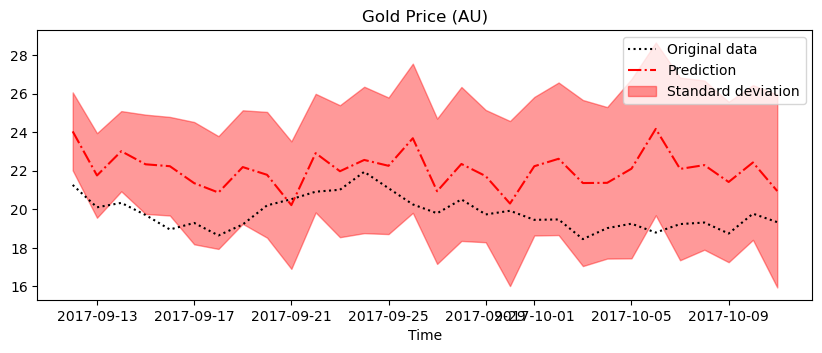

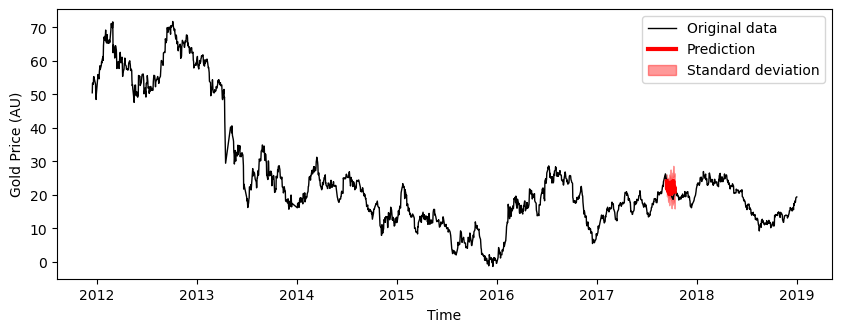

In [12]:
# Die zufällige Sequenz der Testdaten als Input definieren
x_pred0=data[index[0] : index[0] +sequence_length, 0 ] ## zero is correct
x_pred = x_pred0.reshape(1, sequence_length, 1)

y_pred = model(x_pred)

m = y_pred.mean()[0]
s = y_pred.stddev()[0]

start_date2=daten2[index[0],0]

time_pred2 = [start_date2 + timedelta(days=i) for i in range(forecast_length)]

# Prediction wieder zurück normalisieren
m = m/scaler.scale_[0] + scaler.min_[0]
s = s/scaler.scale_[0]

plt.figure(figsize=(10, 3.5))

plt.plot(time_pred2, data[index[0] +sequence_length: index[0] +
              sequence_length+forecast_length , 0 ]/scaler.scale_[0]
         + scaler.min_[0],color='black',linestyle='dotted',
         label='Original data')  # adj

plt.plot(time_pred2, m, color='red', linestyle='dashdot', label='Prediction')
plt.fill_between(time_pred2,  m-s, m+s, color='red', alpha=0.4, label='Standard deviation')
plt.legend()
#plt.xlim([0, 10])
plt.xlabel('Time')
plt.title('Gold Price (AU)')
plt.show()

####plot all
orig = data[:, 0]/scaler.scale_[0] + scaler.min_[0] # Adj Close

plt.figure(figsize=(10, 3.5))
plt.plot(daten2[:, 0], orig, color='black', linewidth=1,
         label='Original data')  # 
plt.plot(time_pred2, m, label='Prediction', color='red', linewidth=3)
plt.fill_between(time_pred2, m-s, m + s,
                 color='red', alpha=0.4, label='Standard deviation')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Gold Price (AU)')
plt.show()
#plt.xlim(daten2[index[0],0]-20, daten2[index[0],0]+20)

# Create and present a forecast for the future

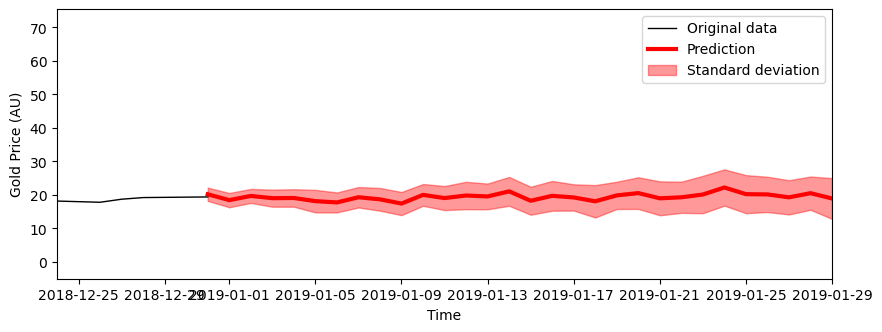

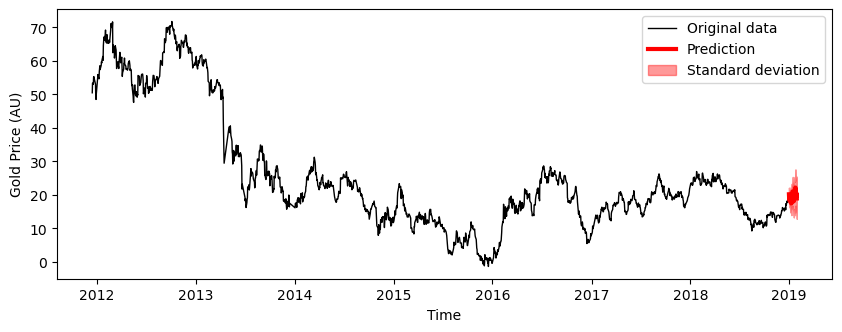

In [13]:
# -sequence_length: This is the last sequence in the data,
#we use it to predict one forcast_length in the future
#we use the first coulmn (0), which is the adj close

x_pred3 = data[-sequence_length: , 0]        # it should be zero  or 1????
x_pred4 = x_pred3.reshape(1, sequence_length, 1)
y_pred3 = model(x_pred4)
m = y_pred3.mean()[0]
s = y_pred3.stddev()[0]
m = m/scaler.scale_[0] + scaler.min_[0]
s = s/scaler.scale_[0]

# Calculate the end date of daten2
end_date = daten2[-1, 0]
# Calculate the time range for prediction starting from the day after the end date of daten2
#time_pred = [end_date + timedelta(days=i) for i in range(1, forecast_length + 1)]
# Calculate the time range for prediction starting from the end date of daten2
time_pred = [end_date + timedelta(days=i) for i in range(forecast_length)]
plt.figure(figsize=(10, 3.5))
plt.plot(daten2[:, 0], orig, color='black', linewidth=1,
         label='Original data')  # 
plt.plot(time_pred, m, label='Prediction', color='red', linewidth=3)
plt.fill_between(time_pred, m-s, m + s,
                 color='red', alpha=0.4, label='Standard deviation')   
d1 = daten2[ld0-5]
d2 = time_pred[-1]
plt.xlim(d1, d2)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Gold Price (AU)')
plt.show()
####
plt.figure(figsize=(10, 3.5))
plt.plot(daten2[:, 0], orig, color='black', linewidth=1,
         label='Original data')  # 
plt.plot(time_pred, m, label='Prediction', color='red', linewidth=3)
plt.fill_between(time_pred, m-s, m + s,
                 color='red', alpha=0.4, label='Standard deviation')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Gold Price (AU)')
plt.show()